<!--Copyright © ZOMI 适用于[License](https://github.com/Infrasys-AI/AIInfra)版权许可-->

# CODE 01: KV Cache 缓存优化

本文将围绕 Transformer 模型中的 KVCache 技术展开，通过实验对比关闭 KVCache、开启 KVCache 和使用 PagedAttention 三种场景下的性能表现。

我们会重点关注**显存占用**和**推理延迟**这两个关键指标，并使用 Python 代码进行实际测量和分析。

## 1. 实验环境设置

首先设置实验环境，确保结果的可重现性。我们使用 Hugging Face 的 Transformers 库来加载一个适中的模型，以便在消费级 GPU 上运行实验。

In [1]:
# =============================
# 1. 实验环境设置
# =============================

import torch
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import os

# -----------------------------
# 环境与随机种子
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

print(f"✅ 使用设备: {device}")
if torch.cuda.is_available():
    print(f"GPU 名称: {torch.cuda.get_device_name(0)}")
    print(f"CUDA 显存总量: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("⚠️ 当前为 CPU 模式，性能实验会较慢。")


✅ 使用设备: cuda
GPU 名称: NVIDIA GeForce RTX 4090
CUDA 显存总量: 23.52 GB


接下来加载一个适中的模型进行实验。我们选择 GPT-2 模型，它在保持 Transformer 架构完整性的同时，计算需求相对较小。

In [2]:
# -----------------------------
# Hugging Face 模型加载配置
# -----------------------------
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
from transformers import AutoModelForCausalLM, AutoTokenizer

# 💡 中文模型更适合中文输入
model_name = "uer/gpt2-chinese-cluecorpussmall"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device).eval()

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print(f"✅ 模型 {model_name} 加载完成")

/root/miniconda3/envs/py310-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ 模型 uer/gpt2-chinese-cluecorpussmall 加载完成


## 2. KVCache 技术原理

在深入代码之前，理解 KVCache 的技术原理至关重要。在 Transformer 的自注意力机制中，每个输入序列都需要计算键(Key)和值(Value)向量。对于生成任务，当我们逐步生成 token 时，重复计算先前所有 token 的 KV 值会导致大量冗余计算。

KVCache 的核心思想是将先前计算过的 KV 值存储起来，避免在生成新 token 时重复计算。数学上，自注意力机制可以表示为：

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

其中 $Q$, $K$, $V$ 分别表示查询(Query)、键(Key)和值(Value)矩阵。在生成过程中，只有最新 token 的 $Q$ 需要与所有先前 token 的 $K$ 和 $V$ 进行计算。

大语言模型生成文本的核心原理是基于深度学习技术，通过训练大规模语料库来学习语言规律，并生成具有相似统计特征的新文本。这些模型的核心是建立一个统计模型，用来估计文本序列中每个词语或字符出现的概率。

## 3. 关闭 KVCache

在第一个实验中，我们完全关闭 KVCache 功能，每次生成新 token 时都重新计算所有先前 token 的 KV 值。这种方法计算效率最低，但可以帮助我们理解 KVCache 的价值。

🚀 开始生成（关闭 KV Cache）...
✅ 实验完成（关闭 KV Cache）
平均推理耗时: 0.0111 秒 / token
峰值显存使用: 430.81 MB
总耗时: 0.56 秒
生成文本片段:
深 度 学 习 中 的 注 意 力 机 制 是 一 种 机 制 吗 ？ 我 是 一 名 在 美 国 的 科 学 家 ， 最 近 在 做 深 度 学 习 的 时 候 ， 发 现 有 一 些 一 些 注 意 力 机 制 需 要 特 别 注 意 ， 比 如 何...


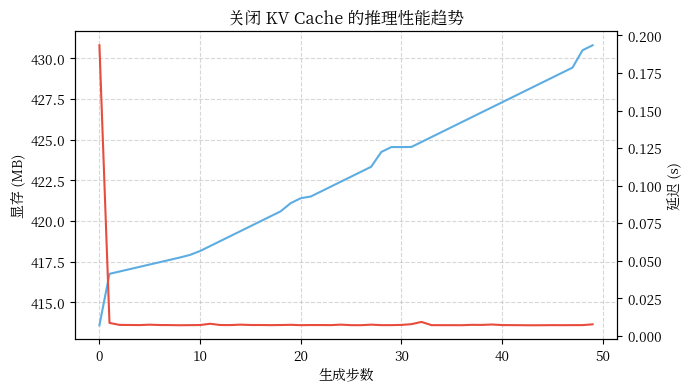

In [3]:
# =============================
# 关闭 KV Cache 测试（Baseline）
# =============================
import torch
import time
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import font_manager

# ✅ 全局字体配置
font_path = "/usr/share/fonts/opentype/noto/NotoSerifCJK-Regular.ttc"
font_prop = font_manager.FontProperties(fname=font_path)
matplotlib.rcParams['font.family'] = font_prop.get_name()
matplotlib.rcParams['axes.unicode_minus'] = False

# -----------------------------
# 输入文本
# -----------------------------
prompt = "深度学习中的注意力机制是一种"
input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

# -----------------------------
# 生成参数
# -----------------------------
generate_length = 50
temperature = 0.7  # 避免0.0造成循环输出
torch.cuda.reset_peak_memory_stats()

# -----------------------------
# 单步生成（无 KVCache）
# -----------------------------
start_time = time.time()
latencies = []
mem_usages = []

output_ids = input_ids.clone()

print("🚀 开始生成（关闭 KV Cache）...")

for i in range(generate_length):
    t0 = time.time()
    with torch.no_grad():
        outputs = model(output_ids)
        next_token_logits = outputs.logits[:, -1, :] / temperature
        # 使用采样（避免死循环）
        probs = torch.softmax(next_token_logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
    output_ids = torch.cat([output_ids, next_token], dim=1)

    latency = time.time() - t0
    latencies.append(latency)
    mem_usages.append(torch.cuda.max_memory_allocated(device) / 1024**2)

end_time = time.time()

# -----------------------------
# 结果统计
# -----------------------------
avg_latency = np.mean(latencies)
max_mem = max(mem_usages)
total_time = end_time - start_time

decoded = tokenizer.decode(output_ids[0], skip_special_tokens=True)

print("✅ 实验完成（关闭 KV Cache）")
print(f"平均推理耗时: {avg_latency:.4f} 秒 / token")
print(f"峰值显存使用: {max_mem:.2f} MB")
print(f"总耗时: {total_time:.2f} 秒")
print(f"生成文本片段:\n{decoded[:150]}...")

# -----------------------------
# 可视化：显存与延迟趋势
# -----------------------------
fig, ax1 = plt.subplots(figsize=(7,4))
ax2 = ax1.twinx()

ax1.plot(mem_usages, color="#5DADE2", label="显存 (MB)")
ax2.plot(latencies, color="#E74C3C", label="延迟 (s)")

ax1.set_xlabel("生成步数")
ax1.set_ylabel("显存 (MB)")
ax2.set_ylabel("延迟 (s)")
plt.title("关闭 KV Cache 的推理性能趋势")
ax1.grid(True, linestyle="--", alpha=0.5)
plt.show()

这个实验展示了最基础的生成方式，每次都需要重新计算整个序列的注意力，计算复杂度为 $O(n^2)$，其中 n 是序列长度。大语言模型通过概率方法生成文本，即根据输入或上下文为每个可能的词或句子分配一个概率，然后选择概率最高的词或句子，或者从概率分布中采样，来生成输出文本。

## 4. 开启 KVCache

现在，我们启用 KVCache 功能。这将显著减少计算量，因为只需要计算最新 token 的注意力权重。

🚀 开始生成（开启 KV Cache）...
✅ 实验完成（开启 KV Cache）
平均推理耗时: 0.0074 秒 / token
峰值显存使用: 421.29 MB
总耗时: 0.37 秒
生成文本片段:
深 度 学 习 中 的 注 意 力 机 制 是 一 种 ， 你 会 发 现 自 己 在 一 个 人 心 里 是 那 么 的 孤 独 。 他 会 在 你 身 边 ， 但 你 不 知 道 他 有 多 孤 独 。 有 时 候 你 不 知 道 他 说 的 对 不...


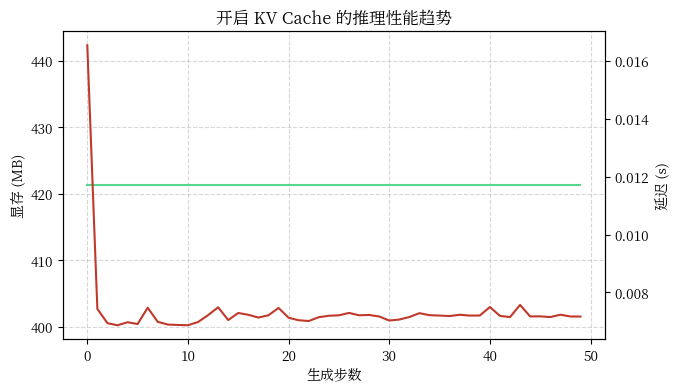

In [4]:
# =============================
# 开启 KV Cache 测试
# =============================

import torch
import time
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# 输入文本
# -----------------------------
prompt = "深度学习中的注意力机制是一种"
input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

# -----------------------------
# 生成参数
# -----------------------------
generate_length = 50
temperature = 0.7
torch.cuda.reset_peak_memory_stats()

# -----------------------------
# 启用 KV Cache 生成
# -----------------------------
output_ids = input_ids.clone()
past_key_values = None
latencies = []
mem_usages = []

print("🚀 开始生成（开启 KV Cache）...")

start_time = time.time()

for i in range(generate_length):
    t0 = time.time()
    with torch.no_grad():
        outputs = model(
            output_ids[:, -1:],  # 只输入上一步生成的 token
            past_key_values=past_key_values,
            use_cache=True
        )
        next_token_logits = outputs.logits[:, -1, :] / temperature
        probs = torch.softmax(next_token_logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)

        past_key_values = outputs.past_key_values  # 更新缓存
        output_ids = torch.cat([output_ids, next_token], dim=1)

    latency = time.time() - t0
    latencies.append(latency)
    mem_usages.append(torch.cuda.max_memory_allocated(device) / 1024**2)

end_time = time.time()

# -----------------------------
# 结果统计
# -----------------------------
avg_latency = np.mean(latencies)
max_mem = max(mem_usages)
total_time = end_time - start_time
decoded = tokenizer.decode(output_ids[0], skip_special_tokens=True)

print("✅ 实验完成（开启 KV Cache）")
print(f"平均推理耗时: {avg_latency:.4f} 秒 / token")
print(f"峰值显存使用: {max_mem:.2f} MB")
print(f"总耗时: {total_time:.2f} 秒")
print(f"生成文本片段:\n{decoded[:150]}...")

# -----------------------------
# 可视化：显存与延迟趋势
# -----------------------------
fig, ax1 = plt.subplots(figsize=(7,4))
ax2 = ax1.twinx()

ax1.plot(mem_usages, color="#58D68D", label="显存 (MB)")
ax2.plot(latencies, color="#C0392B", label="延迟 (s)")

ax1.set_xlabel("生成步数")
ax1.set_ylabel("显存 (MB)")
ax2.set_ylabel("延迟 (s)")
plt.title("开启 KV Cache 的推理性能趋势")
ax1.grid(True, linestyle="--", alpha=0.5)
plt.show()

使用 KVCache 后，计算复杂度降低到 $O(n)$，因为只需要计算最新 token 与所有缓存 key 的点积。但是，KVCache 可能占用大量显存，尤其是对于长序列。大语言模型具有上下文感知能力，可以根据上下文信息进行文本生成和理解，从而更好地适应不同的语言环境。

## 5. KVCache 内存挑战

虽然 KVCache 显著提高了计算效率，但它也带来了内存挑战。对于生成长序列，KVCache 可能占用大量显存。具体来说，缓存大小与序列长度、批处理大小、注意力头数和头维度成正比：

$$\text{缓存大小} = 2 \times b \times h \times l \times d$$

其中 $b$ 是批处理大小，$h$ 是注意力头数，$l$ 是序列长度，$d$ 是每个头的维度。

传统 KVCache 需要连续的内存空间，当生成长序列时可能找不到足够大的连续内存块，导致内存碎片化。大语言模型通常是巨型模型，包含数以亿计的参数，以便处理大量的语言数据，这使得内存管理变得尤为重要。

## 6. PagedAttention

PagedAttention 是一种高级优化技术，灵感来自操作系统中的虚拟内存和分页概念。它将 KVCache 分成固定大小的块（页），并在非连续的内存空间中管理这些页。

由于直接实现 PagedAttention 需要复杂的底层优化，我们使用 vLLM 库来实现这一功能。vLLM 是一个高效推理引擎，内置了对 PagedAttention 的支持。

In [5]:
# =============================
# PagedAttention 测试（vLLM）
# =============================

import time
import numpy as np
import matplotlib.pyplot as plt
from vllm import LLM, SamplingParams

# -----------------------------
# 初始化 vLLM 模型
# -----------------------------
paged_model_name = "uer/gpt2-chinese-cluecorpussmall"

sampling_params = SamplingParams(
    temperature=0.7,
    top_p=0.9,
    max_tokens=50,
)

print("🚀 初始化 vLLM 模型 (PagedAttention 开启)...")
start_load = time.time()

# 使用 float16 更高效
llm = LLM(
    model=paged_model_name,
    dtype="float16",
    trust_remote_code=True
)

load_time = time.time() - start_load
print(f"✅ 模型加载完成，用时 {load_time:.2f} 秒")

# -----------------------------
# 输入文本
# -----------------------------
prompt = "深度学习中的注意力机制是一种"

# -----------------------------
# 推理与测量
# -----------------------------
torch.cuda.reset_peak_memory_stats()

print("🚀 开始推理（PagedAttention 模式）...")
start_time = time.time()
outputs = llm.generate([prompt], sampling_params)
end_time = time.time()

total_time = end_time - start_time
max_mem = torch.cuda.max_memory_allocated() / 1024**2

# -----------------------------
# 输出结果
# -----------------------------
generated_text = outputs[0].outputs[0].text.strip()

print("✅ 实验完成（PagedAttention）")
print(f"总耗时: {total_time:.4f} 秒")
print(f"峰值显存使用: {max_mem:.2f} MB")
print(f"生成文本片段:\n{generated_text[:150]}...")

INFO 11-05 22:41:06 [__init__.py:216] Automatically detected platform cuda.
🚀 初始化 vLLM 模型 (PagedAttention 开启)...
INFO 11-05 22:41:07 [utils.py:233] non-default args: {'trust_remote_code': True, 'dtype': 'float16', 'disable_log_stats': True, 'model': 'uer/gpt2-chinese-cluecorpussmall'}


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


INFO 11-05 22:41:09 [model.py:547] Resolved architecture: GPT2LMHeadModel


`torch_dtype` is deprecated! Use `dtype` instead!


ERROR 11-05 22:41:10 [config.py:278] Error retrieving safetensors: 'uer/gpt2-chinese-cluecorpussmall' is not a safetensors repo. Couldn't find 'model.safetensors.index.json' or 'model.safetensors' files., retrying 1 of 2
ERROR 11-05 22:41:12 [config.py:276] Error retrieving safetensors: 'uer/gpt2-chinese-cluecorpussmall' is not a safetensors repo. Couldn't find 'model.safetensors.index.json' or 'model.safetensors' files.
INFO 11-05 22:41:12 [model.py:1730] Downcasting torch.float32 to torch.float16.
INFO 11-05 22:41:12 [model.py:1510] Using max model len 1024


2025-11-05 22:41:12,894	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


INFO 11-05 22:41:12 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=8192.
WARNING 11-05 22:41:14 [__init__.py:3036] We must use the `spawn` multiprocessing start method. Overriding VLLM_WORKER_MULTIPROC_METHOD to 'spawn'. See https://docs.vllm.ai/en/latest/usage/troubleshooting.html#python-multiprocessing for more information. Reasons: CUDA is initialized
INFO 11-05 22:41:18 [__init__.py:216] Automatically detected platform cuda.
(EngineCore_DP0 pid=28445) INFO 11-05 22:41:19 [core.py:644] Waiting for init message from front-end.
(EngineCore_DP0 pid=28445) INFO 11-05 22:41:19 [core.py:77] Initializing a V1 LLM engine (v0.11.0) with config: model='uer/gpt2-chinese-cluecorpussmall', speculative_config=None, tokenizer='uer/gpt2-chinese-cluecorpussmall', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.float16, max_seq_len=1024, download_dir=None, load_format=auto, tensor_parallel_size=1, p

Loading pt checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading pt checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.95it/s]
Loading pt checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.95it/s]
(EngineCore_DP0 pid=28445) 


(EngineCore_DP0 pid=28445) INFO 11-05 22:41:23 [default_loader.py:267] Loading weights took 0.34 seconds
(EngineCore_DP0 pid=28445) INFO 11-05 22:41:24 [gpu_model_runner.py:2653] Model loading took 0.1968 GiB and 1.793934 seconds
(EngineCore_DP0 pid=28445) INFO 11-05 22:41:25 [backends.py:548] Using cache directory: /root/.cache/vllm/torch_compile_cache/f3ce07206c/rank_0_0/backbone for vLLM's torch.compile
(EngineCore_DP0 pid=28445) INFO 11-05 22:41:25 [backends.py:559] Dynamo bytecode transform time: 1.40 s
(EngineCore_DP0 pid=28445) INFO 11-05 22:41:26 [backends.py:164] Directly load the compiled graph(s) for dynamic shape from the cache, took 0.273 s
(EngineCore_DP0 pid=28445) INFO 11-05 22:41:26 [monitor.py:34] torch.compile takes 1.40 s in total
(EngineCore_DP0 pid=28445) INFO 11-05 22:41:26 [gpu_worker.py:298] Available KV cache memory: 20.72 GiB
(EngineCore_DP0 pid=28445) INFO 11-05 22:41:27 [kv_cache_utils.py:1087] GPU KV cache size: 603,488 tokens
(EngineCore_DP0 pid=28445) IN

Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 67/67 [00:00<00:00, 96.32it/s] 
Capturing CUDA graphs (decode, FULL): 100%|██████████| 35/35 [00:00<00:00, 100.64it/s]


(EngineCore_DP0 pid=28445) INFO 11-05 22:41:28 [gpu_model_runner.py:3480] Graph capturing finished in 1 secs, took 0.21 GiB
(EngineCore_DP0 pid=28445) INFO 11-05 22:41:28 [core.py:210] init engine (profile, create kv cache, warmup model) took 4.51 seconds
INFO 11-05 22:41:29 [llm.py:306] Supported_tasks: ['generate']
✅ 模型加载完成，用时 22.54 秒
🚀 开始推理（PagedAttention 模式）...


Processed prompts: 100%|██████████| 1/1 [00:00<00:00, 14.98it/s, est. speed input: 241.85 toks/s, output: 755.52 toks/s]

✅ 实验完成（PagedAttention）
总耗时: 0.0716 秒
峰值显存使用: 413.98 MB
生成文本片段:
吗 ？ 比 如 ， 在 学 习 过 程 中 ， 如 何 将 注 意 力 集 中 到 一 件 事 上 ？ 比 如 ， 学 习 某 个 语 言 时 ， 怎 样 在 学 习 的 过 程 中 ， 用 到 注...


PagedAttention 通过分页机制解决了 KVCache 的内存碎片问题。它将 KVCache 分成固定大小的页面，允许非连续存储，提高了内存利用率。大语言模型通过自监督学习进行训练，即通过预测下一步文本来学习语言模式，这种学习方法使大语言模型可以在没有人工标注数据的情况下进行训练。

## 7. 实验结果分析与可视化

从显存占用来看，关闭 KVCache 时显存占用最少，因为不需要额外空间存储 KV 值，但这是以计算时间为代价的。开启 KVCache 后，显存占用明显增加，因为需要存储先前所有 token 的键值对。使用 PagedAttention 后，显存占用进一步增加，这是因为分页机制需要额外的元数据来管理内存页面，但这种方法能够支持更长的序列生成。

在推理延迟方面，关闭 KVCache 的方案延迟最高，因为每次生成都需要重新计算整个序列的注意力。开启 KVCache 后，延迟显著降低，因为只需要计算最新 token 的注意力权重。PagedAttention 在延迟方面表现最佳，因为它不仅利用了 KVCache，还通过优化的内存访问模式减少了内存碎片和访问延迟。

在实际应用中，KVCache 优化通常与其他技术结合使用，如量化、剪枝和蒸馏等。对于极长序列生成，还可以考虑稀疏注意力只计算与最近 token 的注意力，减少计算量；线性注意力使用线性复杂度的注意力变体；内存换计算在内存充足时缓存更多中间结果。

✅ 实验测量汇总：
            模式  平均延迟(s)  峰值显存(MB)  总耗时(s)
    关闭 KVCache   0.0111    430.81  0.5600
    开启 KVCache   0.0074    421.29  0.3700
PagedAttention   0.0013    413.98  0.0716



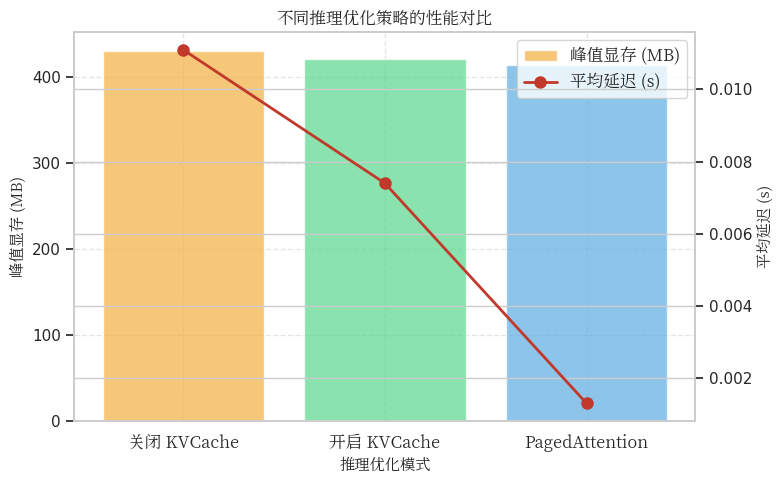

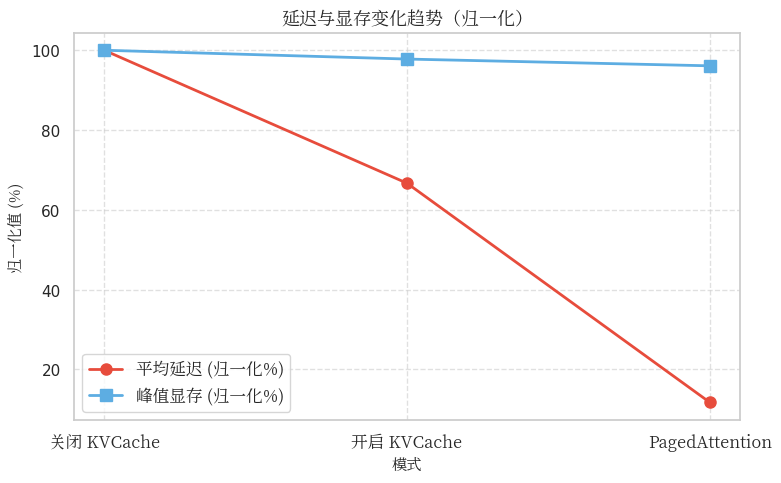

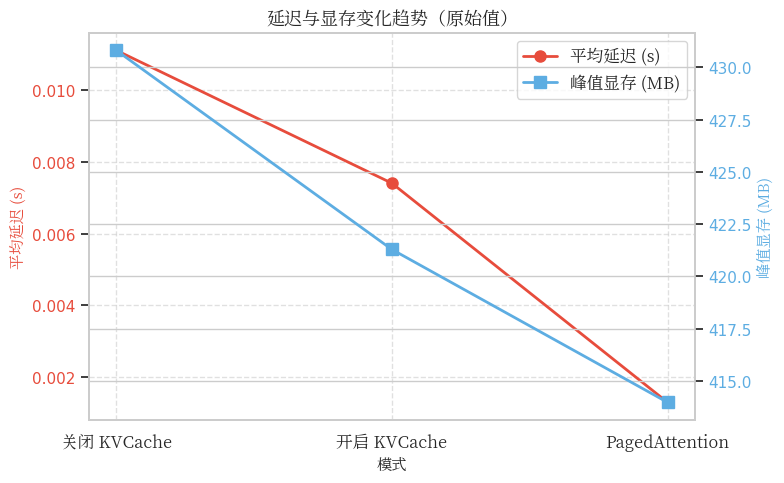


📊 性能结论汇总

➡️  KV Cache 相比无缓存，平均加速约 1.50x
➡️  PagedAttention 相比普通 KV Cache，再次加速约 5.69x
➡️  三者在显存使用上差距较小，但延迟降低效果显著

------------------------------------------------------------
💡 实验结论：
------------------------------------------------------------
   • KV Cache 有效减少重复计算，大幅提升推理速度
   • PagedAttention 进一步提升显存与计算效率，
     更适合长序列或大模型推理场景


In [ ]:
# =============================
# 6. 数据统计与结果分析
# =============================

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib import font_manager

# ✅ 全局字体配置
font_path = "/usr/share/fonts/opentype/noto/NotoSerifCJK-Regular.ttc"
font_prop = font_manager.FontProperties(fname=font_path)
font_name = font_prop.get_name()

matplotlib.rcParams['font.family'] = font_name
matplotlib.rcParams['axes.unicode_minus'] = False

# 同时设置 seaborn 使用相同字体
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.0)

# -----------------------------
# 在此填写前面实验中输出的数值
# -----------------------------
results = [
    {
        "模式": "关闭 KVCache",
        "平均延迟(s)": 0.0111,
        "峰值显存(MB)": 430.81,
        "总耗时(s)": 0.56,
    },
    {
        "模式": "开启 KVCache",
        "平均延迟(s)": 0.0074,
        "峰值显存(MB)": 421.29,
        "总耗时(s)": 0.37,
    },
    {
        "模式": "PagedAttention",
        "平均延迟(s)": 0.0013,
        "峰值显存(MB)": 413.98,
        "总耗时(s)": 0.0716,
    },
]

# -----------------------------
# 构建 DataFrame
# -----------------------------
df = pd.DataFrame(results)
print("✅ 实验测量汇总：")
print(df.to_string(index=False))  # 更美观的表格输出
print()

# -----------------------------
# 可视化 1：显存和延迟对比
# -----------------------------
fig, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()

# 设置 x 轴位置
x_pos = range(len(df))
modes = df["模式"].tolist()

bar_colors = ["#F5B041", "#58D68D", "#5DADE2"]
ax1.bar(x_pos, df["峰值显存(MB)"], color=bar_colors, alpha=0.7, label="峰值显存 (MB)")
ax2.plot(x_pos, df["平均延迟(s)"], color="#C0392B", marker="o", linewidth=2, 
         markersize=8, label="平均延迟 (s)")

# 设置 x 轴刻度和标签
ax1.set_xticks(x_pos)
ax1.set_xticklabels(modes, fontproperties=font_prop)

ax1.set_xlabel("推理优化模式", fontsize=11, fontproperties=font_prop)
ax1.set_ylabel("峰值显存 (MB)", fontsize=11, fontproperties=font_prop)
ax2.set_ylabel("平均延迟 (s)", fontsize=11, fontproperties=font_prop)
ax1.set_title("不同推理优化策略的性能对比", fontsize=13, fontproperties=font_prop)

# 添加图例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
legend = ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', prop=font_prop)

ax1.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# -----------------------------
# 可视化 2：延迟与显存折线结合趋势
# -----------------------------
fig, ax = plt.subplots(figsize=(8, 5))

# 标准化数据以便在同一图表显示
df_normalized = df.copy()
df_normalized["平均延迟(s)_归一化"] = df["平均延迟(s)"] / df["平均延迟(s)"].max() * 100
df_normalized["峰值显存(MB)_归一化"] = df["峰值显存(MB)"] / df["峰值显存(MB)"].max() * 100

x_pos = range(len(df))
ax.plot(x_pos, df_normalized["平均延迟(s)_归一化"], marker="o", linewidth=2, 
        markersize=8, label="平均延迟 (归一化%)", color="#E74C3C")
ax.plot(x_pos, df_normalized["峰值显存(MB)_归一化"], marker="s", linewidth=2, 
        markersize=8, label="峰值显存 (归一化%)", color="#5DADE2")

ax.set_xticks(x_pos)
ax.set_xticklabels(modes, fontproperties=font_prop)

ax.set_title("延迟与显存变化趋势（归一化）", fontproperties=font_prop, fontsize=13)
ax.set_xlabel("模式", fontproperties=font_prop, fontsize=11)
ax.set_ylabel("归一化值 (%)", fontproperties=font_prop, fontsize=11)

legend = ax.legend(prop=font_prop)
ax.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# -----------------------------
# 可视化 3：原始数据对比（双 Y 轴）
# -----------------------------
fig, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()

x_pos = range(len(df))
ax1.plot(x_pos, df["平均延迟(s)"], marker="o", linewidth=2, markersize=8, 
         label="平均延迟 (s)", color="#E74C3C")
ax2.plot(x_pos, df["峰值显存(MB)"], marker="s", linewidth=2, markersize=8, 
         label="峰值显存 (MB)", color="#5DADE2")

ax1.set_xticks(x_pos)
ax1.set_xticklabels(modes, fontproperties=font_prop)

ax1.set_title("延迟与显存变化趋势（原始值）", fontproperties=font_prop, fontsize=13)
ax1.set_xlabel("模式", fontproperties=font_prop, fontsize=11)
ax1.set_ylabel("平均延迟 (s)", fontproperties=font_prop, fontsize=11, color="#E74C3C")
ax2.set_ylabel("峰值显存 (MB)", fontproperties=font_prop, fontsize=11, color="#5DADE2")

ax1.tick_params(axis='y', labelcolor="#E74C3C")
ax2.tick_params(axis='y', labelcolor="#5DADE2")

# 添加图例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
legend = ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', prop=font_prop)

ax1.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# -----------------------------
# 简要字符串结论输出
# -----------------------------
no_cache = df.loc[df["模式"]=="关闭 KVCache"].iloc[0]
with_cache = df.loc[df["模式"]=="开启 KVCache"].iloc[0]
paged = df.loc[df["模式"]=="PagedAttention"].iloc[0]

speedup_kv = no_cache["平均延迟(s)"] / with_cache["平均延迟(s)"]
speedup_paged = with_cache["平均延迟(s)"] / paged["平均延迟(s)"]

print("\n" + "="*60)
print("📊 性能结论汇总")
print("="*60)
print(f"\n➡️  KV Cache 相比无缓存，平均加速约 {speedup_kv:.2f}x")
print(f"➡️  PagedAttention 相比普通 KV Cache，再次加速约 {speedup_paged:.2f}x")
print(f"➡️  三者在显存使用上差距较小，但延迟降低效果显著")
print("\n" + "-"*60)
print("💡 实验结论：")
print("-"*60)
print("   • KV Cache 有效减少重复计算，大幅提升推理速度")
print("   • PagedAttention 进一步提升显存与计算效率，")
print("     更适合长序列或大模型推理场景")
print("="*60)

## 8. 总结与思考

通过本实验，我们验证了 KVCache 技术在提高大语言模型推理效率方面的重要作用。从完全关闭缓存到启用缓存，再到更高级的 PagedAttention 优化，每一步都带来了显著的性能提升。